In [1]:
import rospy
import gym, ray
import numpy as np
import os
import torch.nn as nn

from ray import tune
from ray.rllib.agents import ppo
from ray.tune.registry import register_env
from scouting_gym.tasks.scouting_discrete_task import ScoutingDiscreteTask

from ray.tune import grid_search
from ray.rllib.models import ModelCatalog
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.tf.fcnet import FullyConnectedNetwork
from ray.rllib.models.torch.visionnet import VisionNetwork
import ray.rllib.agents.ppo as ppo
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.agents.dqn import DQNTrainer
from ray.rllib.models.tf.misc import normc_initializer
from ray.tune.logger import pretty_print
from matplotlib import pyplot as plt
# import tensorflow as tf

from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.models.tf.misc import normc_initializer
from ray.rllib.models.utils import get_filter_config
from ray.rllib.policy.sample_batch import SampleBatch
from ray.rllib.policy.view_requirement import ViewRequirement
from ray.rllib.utils.framework import try_import_tf
from ray.rllib.utils.typing import ModelConfigDict, TensorType


Instructions for updating:
non-resource variables are not supported in the long term
None


In [2]:
env = gym.make('Scouting-v0')

print(env.observation_space)

[ERROR] [1611158090.667670, 0.000000]: NOT Initialising Simulation Physics Parameters
[WARN] [1611158090.671167, 0.000000]: Start Init ControllersConnection
[WARN] [1611158090.672099, 0.000000]: END Init ControllersConnection


Box(0.0, 1.0, (40, 128, 1), float32)


In [3]:
env.reset()
for _ in range(100):
    obs, reward, done, _ = env.step(1)
print(obs.min())
print(obs.max())

0.08225308358669281
0.8696321249008179


In [4]:
for _ in range(5):
    obs, reward, done, _ = env.step(1)

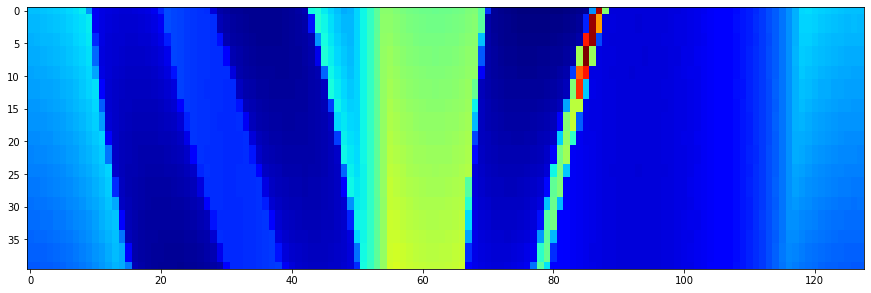

In [5]:
plt.figure(figsize=(15, 10))
plt.imshow(obs.squeeze(), cmap='jet')

In [6]:
class CustomModel(TFModelV2):
    """Example of a keras custom model that just delegates to an fc-net."""

    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name):
        super(CustomModel, self).__init__(obs_space, action_space, num_outputs,
                                          model_config, name)
        self.model = FullyConnectedNetwork(obs_space, action_space,
                                           num_outputs, model_config, name)
        self.register_variables(self.model.variables())

    def forward(self, input_dict, state, seq_lens):
        return self.model.forward(input_dict, state, seq_lens)

    def value_function(self):
        return self.model.value_function()

class MyKerasModel(TFModelV2):
    """Custom model for policy gradient algorithms."""

    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name):
        super(MyKerasModel, self).__init__(obs_space, action_space,
                                           num_outputs, model_config, name)
        self.inputs = tf.keras.layers.Input(
            shape=obs_space.shape, name="observations")

        layer_dense_1 = tf.keras.layers.Dense(
            256,
            name="Dense1",
            activation=tf.nn.relu,
            kernel_initializer=normc_initializer(1.0))(self.inputs)

        layer_dense_2 = tf.keras.layers.Dense(
            128,
            name="Dense2",
            activation=tf.nn.relu,
            kernel_initializer=normc_initializer(1.0))(layer_dense_1)
        layer_out = tf.keras.layers.Dense(
            num_outputs,
            name="my_out",
            activation=None,
            kernel_initializer=normc_initializer(0.01))(layer_dense_2)
        value_out = tf.keras.layers.Dense(
            1,
            name="value_out",
            activation=None,
            kernel_initializer=normc_initializer(0.01))(layer_dense_2)
        self.base_model = tf.keras.Model(self.inputs, [layer_out, value_out])
        self.register_variables(self.base_model.variables)

    def forward(self, input_dict, state, seq_lens):
        model_out, self._value_out = self.base_model(input_dict["obs"])
        return model_out, state

    def value_function(self):
        return tf.reshape(self._value_out, [-1])

    def metrics(self):
        return {"foo": tf.constant(42.0)}

In [7]:
ray.init()

2021-01-20 16:54:58,843	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.178.60',
 'raylet_ip_address': '192.168.178.60',
 'redis_address': '192.168.178.60:6379',
 'object_store_address': '/tmp/ray/session_2021-01-20_16-54-58_337177_183371/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-20_16-54-58_337177_183371/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-01-20_16-54-58_337177_183371',
 'metrics_export_port': 48244,
 'node_id': 'fe7fc79028da9e2b694fc1f8eb29e227923d5394'}

In [8]:
#ModelCatalog.register_custom_model(
#    "my_model", VisionNetwork)

config = {
    "env": ScoutingDiscreteTask,  # or "corridor" if registered above
    "env_config": {
        "corridor_length": 5,
    },
    # Use GPUs iff `RLLIB_NUM_GPUS` env var set to > 0.

    "num_gpus": int(os.environ.get("RLLIB_NUM_GPUS", "0")),
    "num_workers": 1,  # parallelism
    "model": {
        "dim": 40,
        "conv_filters": [[16, [3, 3], 2], [32, [3, 3], 2], [64, [3, 3], 2], [512, [5, 16], 1]]
    }
}

stop = {
    "training_iteration": 500,
    "timesteps_total": 1000000
}

In [9]:
trainer = DQNTrainer(config=config)
policy = trainer.get_policy()

2021-01-20 16:54:59,527	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-01-20 16:54:59,527	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=183918) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=183918) Instructions for updating:
(pid=183918) non-resource variables are not supported in the long term
(pid=183918) [ERROR] [1611158102.462749, 0.000000]: NOT Initialising Simulation Physics Parameters
(pid=183918) [WARN] [1611158102.466446, 0.000000]: Start Init ControllersConnection
(pid=183918) [WARN] [1611158102.467619, 0.000000]: END Init ControllersConnection
2021-01-20 16:55:06,807	WARNING util.py:43 -- Install gputil for GPU system monitori

(pid=183918) None


In [10]:
print(policy.q_model.base_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
observations (InputLayer)    [(None, 40, 128, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 20, 64, 16)        160       
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 32, 32)        4640      
_________________________________________________________________
conv3 (Conv2D)               (None, 5, 16, 64)         18496     
_________________________________________________________________
conv_out (Conv2D)            (None, 1, 1, 256)         1310976   
_________________________________________________________________
lambda (Lambda)              (None, 256)               0         
_________________________________________________________________
value_out (Dense)            (None, 1)                 257   

In [ ]:
results = []
for i in range(1000):
    result = trainer.train()
    results.append(result)

    if i % 5 == 0:
        checkpoint = trainer.save()
        print("checkpoint saved at", checkpoint)

    if i % 20 == 0:
        print(pretty_print(result))

(pid=183918) 2021-01-20 16:55:08,072	WARNING deprecation.py:29 -- DeprecationWarning: `env_index` has been deprecated. Use `episode.env_id` instead. This will raise an error in the future!
(pid=183918) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/ray/rllib/policy/tf_policy.py:850: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
(pid=183918) Instructions for updating:
(pid=183918) Prefer Variable.assign which has equivalent behavior in 2.X.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
checkpoint saved at /home/dschori/ray_results/DQN_ScoutingDiscreteTask_2021-01-20_16-54-59lyd541r8/checkpoint_1/checkpoint-1
custom_metrics: {}
date: 2021-01-20_16-55-51
done: false
episode_len_mean: 217.0
episode_reward_max: -9.48386934399604
episode_reward_mean: -17.952207008562997
episode_reward_min: -30.281293196976286
episodes_this_iter: 4
episodes_total: 4
experiment_id: edb6d68436c946bebc38760b32ead996
hostname: workstation
info:
  last_target_update_ts: 1000
  learner:
    default_policy:
      cur_lr: 0.0005000000237487257
      max_q: 0.01926347427070141
      mean_q: 0.0034192039165645838
      mean_td_error: 0.026814233511686325
      min_q: -0.011487864889204502
      model: {}
  num_steps_sampled: 1000
  num_steps_trained: 32
  num_target_updates: 1
iterations_since_restore: 1
node_ip: 192.168.178.60
num_healthy_workers: 1
off_policy_estimator: {}
perf:
  cpu_util_percent: 51.733846153